Num GPUs Available:  1


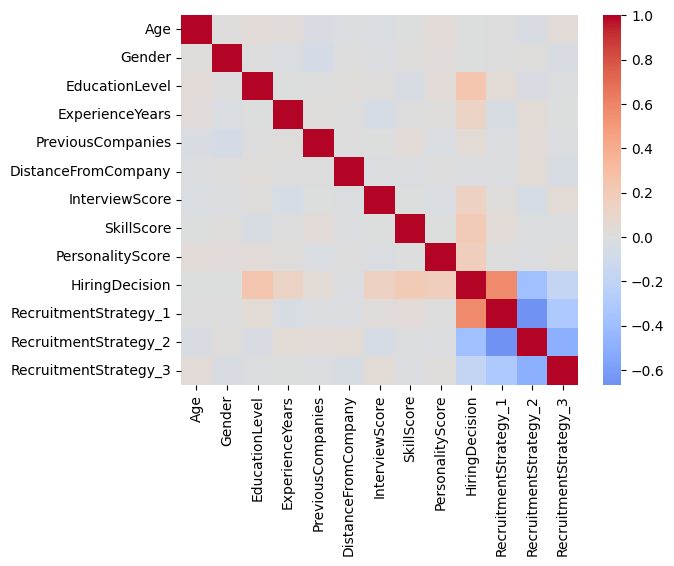

In [7]:
import numpy
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
import seaborn
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


recrutamento = pd.read_csv('recruitment_data.csv', sep=',', decimal='.')

# Instanciando o objeto One-Hot encoder, pois vai ser utilizada na coluna recrutamento Strategy
ohe = OneHotEncoder(handle_unknown='ignore')
# Fazendo a transformação
ohe_df = pd.DataFrame(ohe.fit_transform(recrutamento[['RecruitmentStrategy']]).toarray(), columns=['RecruitmentStrategy_1','RecruitmentStrategy_2','RecruitmentStrategy_3'])

# Agrupando a nova coluna com o df original
df = recrutamento.join(ohe_df)

recrutamento = df.drop(['RecruitmentStrategy'], axis=1)


corrPearson = recrutamento.corr('pearson')

seaborn.heatmap(corrPearson, annot=False, cmap='coolwarm', center=0)

features = list(recrutamento.columns.values)

classificacao = 'HiringDecision'

corrKendall = recrutamento.corr('kendall')

corrPearson = recrutamento.corr('pearson')

corrSpearman = recrutamento.corr('spearman')

tabela_correlacoes = pd.DataFrame()

tabela_correlacoes['kendal']= corrKendall['HiringDecision'].sort_values(ascending=False)
tabela_correlacoes['pearson']= corrPearson['HiringDecision'].sort_values(ascending=False)
tabela_correlacoes['spearman']= corrSpearman['HiringDecision'].sort_values(ascending=False)

tabela_correlacoes.drop(tabela_correlacoes[tabela_correlacoes['kendal']==1].index, inplace=True)

tabela_correlacoes

#Verifica-se que a estrategia de recrutamento  =1 que eh a agressiva, vai impactar muito na decisao final de contratacao

#removendo as features que tiveram indice de correlacao menor que 0.1
#tabela_correlacoes[tabela_correlacoes['kendal']<0.1].index

features.remove('PreviousCompanies')
features.remove('Age')
features.remove('Gender')
features.remove('DistanceFromCompany')

#Remove o output
features.remove(classificacao)

X = recrutamento[features].to_numpy() 
Y = recrutamento[classificacao].to_numpy() 



<AxesSubplot:xlabel='HiringDecision', ylabel='count'>

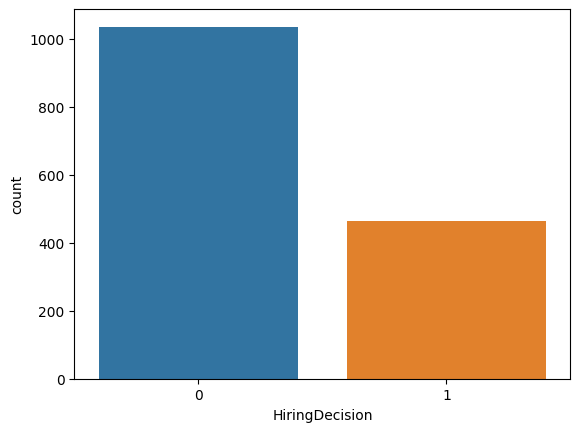

In [6]:
#Verificando que os dados estao desbalanceados
seaborn.countplot(x=classificacao,data=recrutamento)

In [8]:
#Eh interessante aplicar  o SMOTE para reduzir o vies em direcao a classe de " Nao contratados "
#A tecnica de SMOTE gera dados pra classe menos favorecida utilizando tecnica de KNN e ao mesmo tempo interpolacao

oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)


<AxesSubplot:ylabel='count'>

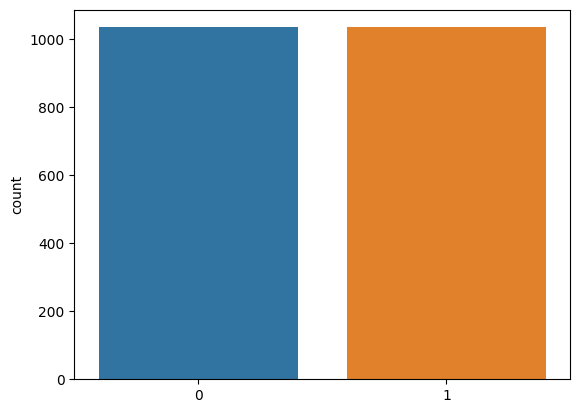

In [8]:
#Agora os dados estao balanceados
seaborn.countplot(x=Y)


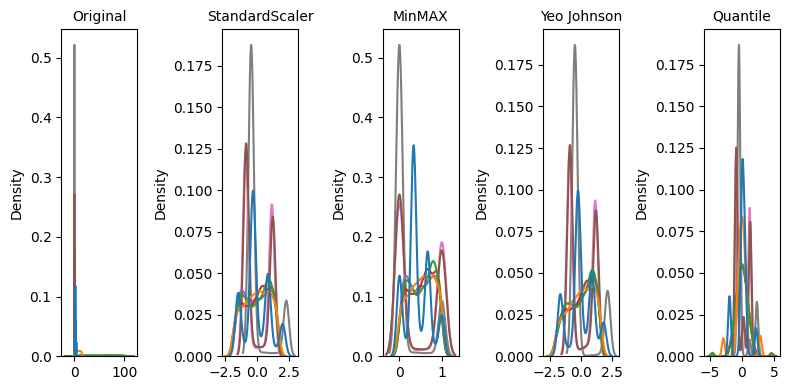

In [9]:
import matplotlib.pyplot as plt
STANDARD_SCALER = StandardScaler()
X_normalizado_standard = STANDARD_SCALER.fit_transform(X)


MIN_MAX_SCALER = MinMaxScaler(feature_range=(0, 1))
X_normalizado_min_max = MIN_MAX_SCALER.fit_transform(X)




from sklearn.preprocessing import PowerTransformer, QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')


pt = PowerTransformer(method='yeo-johnson')

teste_yeo_johnson = pt.fit_transform(X)
teste_yeo_johnson = STANDARD_SCALER.fit_transform(teste_yeo_johnson)

teste_quantile = qt.fit_transform(X)
teste_quantile = STANDARD_SCALER.fit_transform(teste_quantile)


f, axs = plt.subplots(1, 5, figsize=(8, 4))
seaborn.kdeplot(X, ax=axs[0], legend=False,)
axs[0].set_title('Original', size=10)

seaborn.kdeplot(X_normalizado_standard, ax=axs[1], legend=False,)
axs[1].set_title('StandardScaler', size=10)

seaborn.kdeplot(X_normalizado_min_max, ax=axs[2], legend=False,)
axs[2].set_title('MinMAX', size=10)


seaborn.kdeplot(teste_yeo_johnson, ax=axs[3], legend=False)
axs[3].set_title('Yeo Johnson', size=10)

seaborn.kdeplot(teste_quantile, ax=axs[4], legend=False)
axs[4].set_title('Quantile', size=10)

f.tight_layout()

X_transformado = teste_quantile




In [10]:
# PARAMETROS DA REDE 
from enum import Enum

class LossFunction(Enum):
    MSE = "mse"
    BINARY_CROSS = "binary_crossentropy"
    CATEGORICAL_CROSS="categorical_crossentropy"


class Optimizer(Enum):
    ADAM = "adam"
    RMSPROP="rmsprop"
    SGD="sgd"

class Activation(Enum):
    SIGMOID = "sigmoid"
    TANH="tanh"
    RELU="relu"
    

class Metrics(Enum):
    ACCURACY = "accuracy"
    PRECISION="precision"
    RECALL="recall"


class KernelInit(Enum):
    UNIFORM= "uniform"
    NORMAL= "normal"
    HENORMAL="he_normal"
    GLOROTNORMAL ="glorot_normal"
    HEUNIFORM = "he_uniform"

In [12]:
from tensorflow.keras import layers, regularizers


funcoes_ativacao = [Activation.TANH.value ]#, Activation.RELU.value] 
metrica = Metrics.ACCURACY.value
# SEED que controla a aleatoriedade 
random_seed = 22
tf.random.set_seed(random_seed)
# define the grid search parameters
neurons = [ X_transformado.shape[1]*10] #, X_transformado.shape[1]*3,X_transformado.shape[1]*4]
hidden_layers =[1] 
loss_function=[LossFunction.MSE.value]
optimezer_to_test= [Optimizer.ADAM.value]
lr = 0.001

def create_model(neurons, activation, hidden_layers, loss_function, optimizer):

    optimizer_instance = None
    if(optimizer == Optimizer.ADAM.value):
        optimizer_instance = tf.keras.optimizers.Adam(learning_rate=lr)
    elif(optimizer == Optimizer.RMSPROP.value):
        optimizer_instance = tf.keras.optimizers.RMSprop(learning_rate=lr)
    elif(optimizer == Optimizer.SGD.value):
        optimizer_instance = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)


    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(neurons, input_shape=(X_transformado.shape[1],),  activation=activation,
                                    kernel_initializer=KernelInit.GLOROTNORMAL.value))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(neurons, input_shape=(X_transformado.shape[1],),  activation=activation,
                                    kernel_initializer=KernelInit.GLOROTNORMAL.value))
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Dense(1, activation=Activation.SIGMOID.value))

    model.compile(loss=loss_function, optimizer=optimizer_instance, metrics=[Metrics.ACCURACY.value])
    return model

# create model
model = KerasClassifier(model=create_model, verbose=0)
es_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
es_metric = tf.keras.callbacks.EarlyStopping(monitor=metrica, mode='max', patience=100, min_delta=0.1, restore_best_weights=True)

param_grid = dict(epochs=[2000], model__neurons=neurons, model__activation=funcoes_ativacao,
                  model__hidden_layers= hidden_layers, model__loss_function= loss_function,
                  model__optimizer = optimezer_to_test  )
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=10)
grid_result = grid.fit(X_transformado, Y, validation_split = 0.2, callbacks=[es_loss, es_metric]) 
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))




Best: 0.948309 using {'epochs': 2000, 'model__activation': 'tanh', 'model__hidden_layers': 1, 'model__loss_function': 'mse', 'model__neurons': 80, 'model__optimizer': 'adam'}
0.948309 (0.046036) with: {'epochs': 2000, 'model__activation': 'tanh', 'model__hidden_layers': 1, 'model__loss_function': 'mse', 'model__neurons': 80, 'model__optimizer': 'adam'}


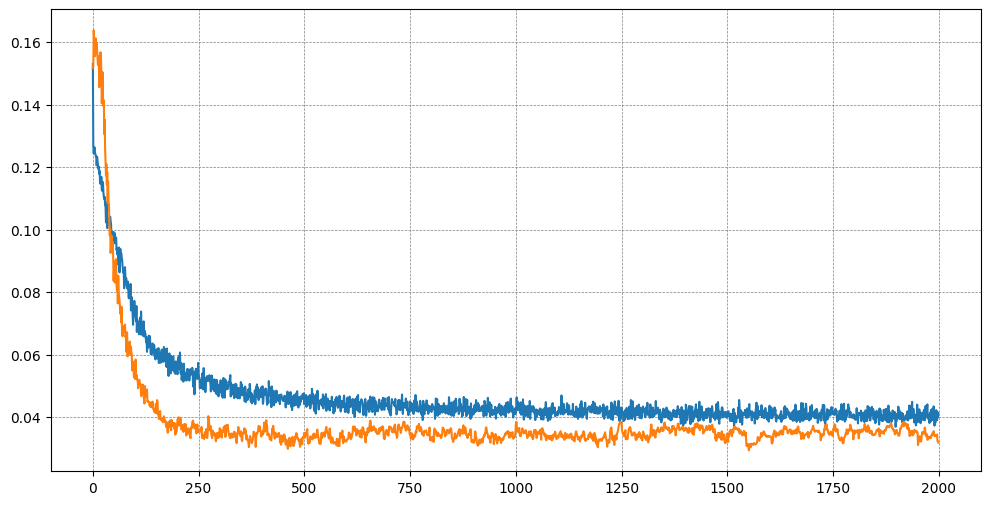

In [15]:
from matplotlib import pyplot


# PLOT TRAINING HISTORY
fig = pyplot.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
_ = ax.plot(grid_result.best_estimator_.history_['loss'], label='loss')
_ = ax.plot(grid_result.best_estimator_.history_['val_loss'], label='val_loss')
_ = ax.grid(which='major', linestyle='--', linewidth='0.5', color='gray')

In [32]:
win_model = grid_result.best_estimator_.model_

model_json = win_model.to_json()
with open("deploy/model/model.json", "w") as json_file:
    json_file.write(model_json)

#salvando os pesos aprendidos pela rede neural
win_model.save_weights("deploy/model/weights.h5")

In [19]:
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model


this_folder = pathlib.Path.cwd()
data_folder = this_folder/"deploy"
json_file = open(data_folder/"model"/"model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(data_folder/"model"/"weights.h5")

loaded_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

X_teste = [[ 1.,  1., 45., 23., 22.,  0.,  0.,  1.]]

y_predict = loaded_model.predict(X_teste)


y_predict

1/1 [==============================] - 0s 109ms/step


array([[1.]], dtype=float32)

In [57]:
print(X[0])
print(X_transformado[0])
STANDARD_SCALER = StandardScaler()
X_normalizado_standard = STANDARD_SCALER.fit_transform(X)


teste_quantile = qt.fit_transform(X)

STANDARD_SCALER.fit(teste_quantile)
novo_registro_transformado = STANDARD_SCALER.transform(qt.transform([X[0]]))

print(novo_registro_transformado)

[ 2.  0. 48. 78. 91.  1.  0.  0.]
[ 0.03490881 -2.88141343 -0.13437011  0.56764712  1.14457432  1.28199052
 -0.91989987 -0.46776527]
[[ 0.03490881 -2.88141343 -0.13437011  0.56764712  1.14457432  1.28199052
  -0.91989987 -0.46776527]]


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X_transformado,
                                                                  Y,
                                                                  test_size = 0.3,
                                                                  random_state = 0)


y_predict = grid_result.best_estimator_.predict([[ 2. , 0., 48. ,78., 91.  ,1. , 0. , 0.]])


y_2_=   grid_result.best_estimator_.predict([[ 0.03490881, -2.88141343 ,-0.13437011 , 0.56764712,  1.14457432, 1.28199052,
 -0.91989987 ,-0.46776527]])


y_predict = grid_result.best_estimator_.predict([X[2]])


y_predict_ = grid_result.best_estimator_.predict([X_transformado[2]])

# Acurácia
accuracy = accuracy_score(y_teste, y_predict)
print("Acurácia:", accuracy)


# Precisão
precision = precision_score(y_teste, y_predict)
print("Precisão:", precision)

# Recall
recall = recall_score(y_teste, y_predict)
print("Recall:", recall)

# Especificidade.
tn, fp, fn, tp = confusion_matrix(y_teste, y_predict).ravel()
specificity = tn / (tn + fp)
print("Especificidade:", specificity)

# F1 Score
f1 = f1_score(y_teste, y_predict)
print("F1 Score:", f1)

# Os valores percentuais da previsão
# predict_proba retorna a probabilidade de cada classe, o primeiro valor é a probabilidade de ser 0 e o segundo de ser 1
previsoes_percent = grid_result.best_estimator_.predict_proba(X_teste)
# As probabilidades de 1, usaremos para a função ROC
previsoes_percent = previsoes_percent[:,1]
previsoes_percent

# ROC AUC Score (necessita das probabilidades de classe em vez de previsões).
# Para calcular a ROC AUC é necessário passar a probabilidade de ser 1.
roc_auc = roc_auc_score(y_teste, previsoes_percent)
print("ROC AUC Score:", roc_auc)

from sklearn.metrics import ConfusionMatrixDisplay
fig = ConfusionMatrixDisplay.from_predictions(y_teste, y_predict , display_labels=['Not Hired', 'Hired'], cmap='Greens')
plt.title(grid_result.best_params_)
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [621, 1]

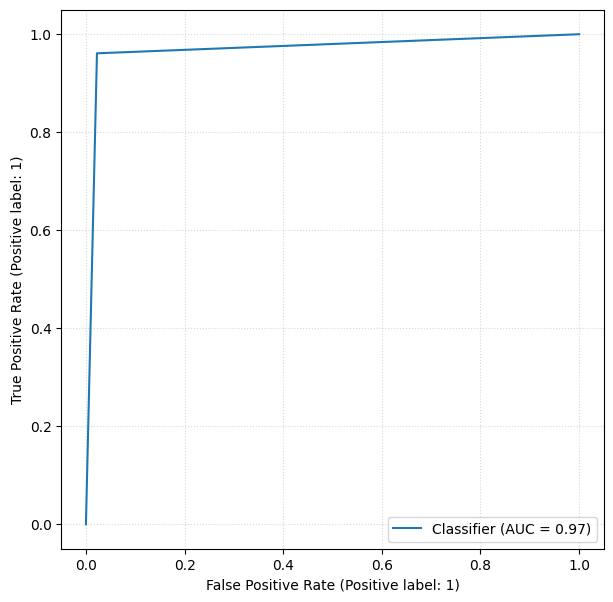

In [21]:
from sklearn.metrics import RocCurveDisplay
from matplotlib import pyplot

fig = pyplot.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)
_ = RocCurveDisplay.from_predictions(y_teste, y_predict, ax=ax)
_ = ax.grid(alpha=0.5, ls=':')

Acurácia: 0.9468599033816425
Precisão: 0.9537953795379538
Recall: 0.9383116883116883
Especificidade: 0.9552715654952076
F1 Score: 0.9459901800327332
ROC AUC Score: 0.9666870669266836


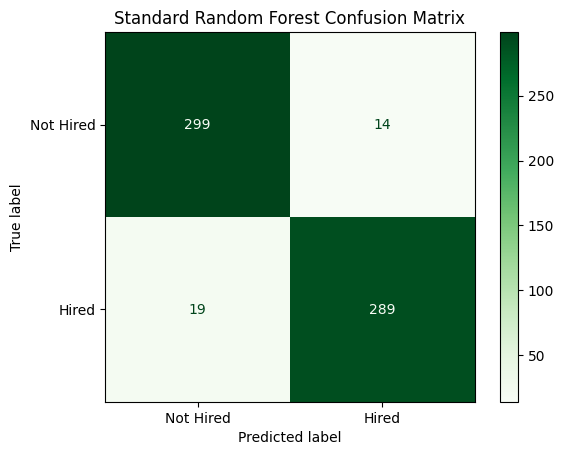

In [22]:

#IMPLEMENTANDO O RANDOMFOREST SEM BALANCEAMENTO
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


# Divisão da base de dados entre treinamento e teste (30% para testar e 70% para treinar)
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X_transformado,
                                                                  Y,
                                                                  test_size = 0.3,
                                                                  random_state = 0)
# Criação do modelo e treinamento
# Funciona por meio de votação, ou seja, a classe que tiver mais votos é a classe que o modelo vai escolher
floresta = RandomForestClassifier(n_estimators = 100)
floresta.fit(X_treinamento, y_treinamento)

previsoes = floresta.predict(X_teste)

# Os valores percentuais da previsão
# predict_proba retorna a probabilidade de cada classe, o primeiro valor é a probabilidade de ser 0 e o segundo de ser 1
previsoes_percent = floresta.predict_proba(X_teste)
# As probabilidades de 1, usaremos para a função ROC
previsoes_percent = previsoes_percent[:,1]
previsoes_percent


matriz_confusao = confusion_matrix(y_teste, previsoes)
matriz_confusao

# Acurácia
accuracy = accuracy_score(y_teste, previsoes)
print("Acurácia:", accuracy)

# Precisão
precision = precision_score(y_teste, previsoes)
print("Precisão:", precision)

# Recall
recall = recall_score(y_teste, previsoes)
print("Recall:", recall)

# Especificidade.
tn, fp, fn, tp = confusion_matrix(y_teste, previsoes).ravel()
specificity = tn / (tn + fp)
print("Especificidade:", specificity)

# F1 Score
f1 = f1_score(y_teste, previsoes)
print("F1 Score:", f1)

# ROC AUC Score (necessita das probabilidades de classe em vez de previsões).
# Para calcular a ROC AUC é necessário passar a probabilidade de ser 1.
roc_auc = roc_auc_score(y_teste, previsoes_percent)
print("ROC AUC Score:", roc_auc)

fig = ConfusionMatrixDisplay.from_estimator(floresta, X_teste, y_teste, display_labels=['Not Hired', 'Hired'], cmap='Greens')
plt.title('Standard Random Forest Confusion Matrix')
plt.show()

